# Note:
- The 3-year survival binary classification for candidate and donor with scaled features, excluding any Max Gini Impurity < 5% on every feature after all encoding.
- Candidate ONLY

In [1]:
# path to user functions
import sys  
sys.path.append('../Src/')

from platform import python_version

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import importlib 
from sklearn.preprocessing import OrdinalEncoder

# import user functions
import UserUtilityFunctions as uf
# import UserStatisticalFunctions as usf
import UserVisualization as uv
import UserMetricsFunctions as umf

# set seaborn theme
sns.set_theme()

# initializing variables
RANDOM_STATE = 1776

# print versions
print("Numpy Version: " + np.__version__)
print("Pandas Version: " + pd.__version__)
print("Seaborn Version: " + sns.__version__)
print("Matplotlib Version: " + plt.matplotlib.__version__)
print("Python Version: " + python_version())

# adjust pandas display options to max
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
# adjust pandas display options to ensure full display of content
pd.set_option('display.max_colwidth', None)

Numpy Version: 1.26.4
Pandas Version: 2.2.3
Seaborn Version: 0.13.2
Matplotlib Version: 3.9.2
Python Version: 3.9.20


### Import Dataset

In [2]:
# import data
df = pd.read_pickle("../Data/6aClean_ML_Heart_CAT.pkl")
df_ordinal = pd.read_pickle("../Data/6aClean_ML_ordinal.pkl")
df_nominal = pd.read_pickle("../Data/6aClean_ML_nominal.pkl")
df_can = pd.read_pickle("../Data/6aClean_ML_CAN.pkl")
df_don = pd.read_pickle("../Data/6aClean_ML_DON.pkl")
df_both = pd.read_pickle("../Data/6aClean_ML_BOTH.pkl")
df_label = pd.read_pickle("../Data/6aClean_ML_label.pkl")
# print shape
print(f"Heart Dataset Rows: {df.shape[0]:,} & Columns: {df.shape[1]:,}")
print(f"Nominal Features: {df_nominal.shape[0]:,}")
print(f"Ordinal Features: {df_ordinal.shape[0]:,}")
print(f"Candidate Features: {df_can.shape[0]:,}")
print(f"Donor Features: {df_don.shape[0]:,}")
print(f"Both Features: {df_both.shape[0]:,}")
print(f"Label Features: {df_label.shape[0]:,}")

Heart Dataset Rows: 27,494 & Columns: 100
Nominal Features: 50
Ordinal Features: 47
Candidate Features: 29
Donor Features: 44
Both Features: 24
Label Features: 2


In [3]:
# combine two lists
allCat = df_ordinal.column.to_list() + df_nominal.column.to_list()

# insanity check
uf.symmetricDifference(set(allCat), set(df.columns.to_list()))

Symmetric difference: ['LengthOfStay', 'Survival', 'TransplantSurvivalDay']


### Candidate Features ONLY

In [4]:
def HouseKeeping(data, removeColLst, dataCAN, dataDON, dataOrdinal, dataNominal, dataBoth, display=True):
    """
    Run helper fuction for house keeping
    """
    # remove DataFrame data (house keeping)
    dataCAN = uf.removeRowUsingMask(dataCAN, removeColLst, colstr='column', string='df_can', display=display)
    dataDON = uf.removeRowUsingMask(dataDON, removeColLst, colstr='column', string='df_don', display=display)
    dataOrdinal = uf.removeRowUsingMask(dataOrdinal, removeColLst, colstr='column',  string='df_ordinal', display=display)
    dataNominal = uf.removeRowUsingMask(dataNominal, removeColLst, colstr='column', string='df_nominal',  display=display)
    dataBoth = uf.removeRowUsingMask(dataBoth, removeColLst, colstr='column', string='df_both',  display=display)

    # remove features
    data = uf.removeColumn(data, removeColLst, display=display)

    return data, dataCAN, dataDON, dataOrdinal, dataNominal, dataBoth

In [5]:
# add to removeCols
removeCols = df_don.column.to_list()
removeCols.extend(df_label.column.to_list())

# remove all Donor features
df, df_can, df_don, df_ordinal, df_nominal, df_both = HouseKeeping(df, removeCols, df_can, df_don, df_ordinal, df_nominal, df_both, display=True)

Remove 0 row(s) from df_can DataFrame.
Remove 44 row(s) from df_don DataFrame.
Remove 12 row(s) from df_ordinal DataFrame.
Remove 32 row(s) from df_nominal DataFrame.
Remove 0 row(s) from df_both DataFrame.

Removed Features: ['AllocationType_DON', 'AntiHypertensive_DON', 'AntibodyResultHBSAB_DON', 'AntibodyResultRPR_VDRL_DON', 'Antibody_HEP_C_DON', 'Antigen_Positive_Count_DON', 'ArginnieManagement_DON', 'BloodPH_CAT_DON', 'BloodUreaNitrogenLevel_CAT_DON', 'Bronchoscopy_Abnormal_Count_DON', 'Cancer_Yes_Count_DON', 'CardiacArrest_DON', 'CauseOfDeath_DON', 'ChestXray_DON', 'CigaretteHistory_DON', 'CoronaryAngiogram_DON', 'DeceasedRetyped_DON', 'Diabetes_DON', 'Diuretics_Yes_Count_DON', 'DrugUse_Yes_Count_DON', 'EpsteinBarr_Positive_Count_DON', 'Ethnicity_DON', 'HeavyAlcoholUse_DON', 'Hematocrit_CAT_DON', 'HeparinManagement_DON', 'HypertensionHistory_DON', 'Infection_Yes_Count_DON', 'InotropicAgent_DON', 'InsulinManagement_DON', 'IntropicMedicationProcurement_DON', 'KidneyAllocation_DON',

In [6]:
print(sorted(df_both.column.to_list()))

['Age_Addition_CAT', 'BMI_Addition_CAT', 'BloodGroupMatchLevel', 'Citizenship_Difference', 'Creatinine_Addition_CAT', 'CrossMatchDone', 'DistanceFromDonorHospitaltoTXCenter_CAT', 'Gender_Difference', 'HBV_NAT_Positive_Count', 'HCV_NAT_Positive_Count', 'HIV_Positive_Count', 'HeightCm_Addition_CAT', 'Hepatitis_B_Positive_Count', 'IschemicTimeHour_CAT', 'MismatchLevel_AMIS', 'MismatchLevel_BMIS', 'MismatchLevel_DRMIS', 'MismatchLevel_HLMIS', 'SteroidsUse_Yes_Count', 'SurfaceAntigenHEP_B_Positive_Count', 'TotalBilirubin_Addition_CAT_DON', 'Transfusion_Yes_Count', 'TransplantRegion', 'WeightKg_Addition_CAT']


#### Survival Plot

Heart Dataset Rows: 27,069 & Columns: 54


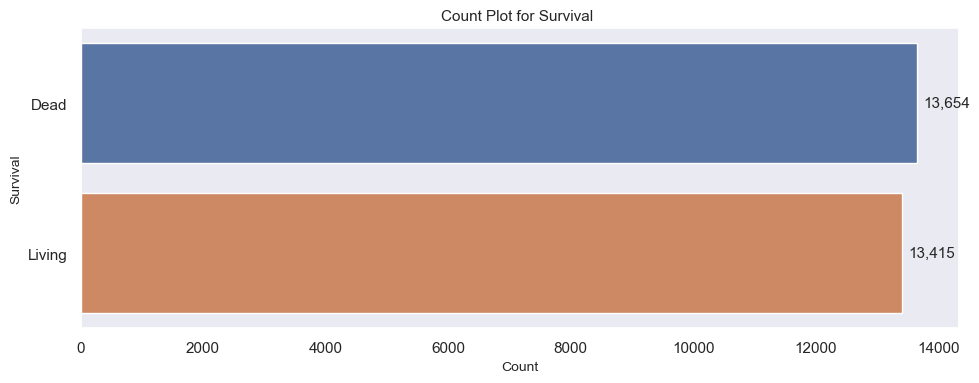

In [6]:
# remove rows where Survival is NaN
df = df.dropna(subset=['Survival'])
# print
print(f"Heart Dataset Rows: {df.shape[0]:,} & Columns: {df.shape[1]:,}")
# plot
uv.countPlot(df, ['Survival'], figsize=(10, 4))

#### Display nominal & ordinal Data

In [7]:
# display all nominal values
df[df_nominal.column.to_list()].head()

,BloodGroupMatchLevel,PrimaryDiagnosisType_CAN,InfectionTherapyIV_CAN,DiabetesType_CAN,CerebroVascularDisease_CAN,DefibrillatorImplantRegistration_CAN,CigaretteUse_CAN,StatusAtTransplant_CAN,Ethnicity_CAN,HeartProcedureType_CAN,TransplantRegion,PriorLungSurgeryAfterRegistration_CAN,EpsteinBarrSeroStatusTransplant_CAN,CMVStatus_Transplant_CAN,HEP_C_SerostatusStatus_CAN,CrossMatchDone,Citizenship_Difference,Gender_Difference
0,Identical,DILATED MYOPATHY: IDIOPATHIC,No,No,No,Yes,No,Hypoplastic Left Heart Syndrome; Atrioventricular Septal Defect; Other left Heart Valvar/Structural,Hispanic,Orthotopic Bicaval,Region 5,No,Unknown,Positive,Negative,No,True,True
1,Identical,DILATED MYOPATHY: IDIOPATHIC,No,No,No,Yes,No,Transposition of the Great Arteries; Truncus Arteriosus; Congenitally Corrected Transposition (L-TGA),Hispanic,Orthotopic Bicaval,Region 4,No,Positive,Positive,Negative,Yes,False,True
2,Identical,DILATED MYOPATHY: ISCHEMIC,No,No,No,No,No,Hypoplastic Left Heart Syndrome; Atrioventricular Septal Defect; Other left Heart Valvar/Structural,"White, Non-Hispanic",Orthotopic Bicaval,Region 9,No,Positive,Negative,Negative,Yes,True,True
3,Identical,DILATED MYOPATHY: ISCHEMIC,No,No,No,No,Yes,Hypoplastic Left Heart Syndrome; Atrioventricular Septal Defect; Other left Heart Valvar/Structural,"White, Non-Hispanic",Orthotopic Bicaval,Region 9,No,Positive,Negative,Negative,Yes,True,False
4,Identical,DILATED MYOPATHY: IDIOPATHIC,No,No,No,Yes,No,Hypoplastic Left Heart Syndrome; Atrioventricular Septal Defect; Other left Heart Valvar/Structural,"White, Non-Hispanic",Orthotopic Bicaval,Region 11,No,Positive,Positive,Negative,Yes,True,False


In [8]:
# display all ordinal values
df[df_ordinal.column.to_list()].head()

,MismatchLevel_AMIS,MismatchLevel_HLMIS,MismatchLevel_BMIS,MismatchLevel_DRMIS,PreviousTransplantNumber_CAN,EducationLevel_CAN,FunctionalStatusTransplant_CAN,MedicalConditionTransplant_CAN,Age_Addition_CAT,HeightCm_Addition_CAT,WeightKg_Addition_CAT,BMI_Addition_CAT,Creatinine_Addition_CAT,DistanceFromDonorHospitaltoTXCenter_CAT,Hemodynamics_Addition_CAT_CAN,IschemicTimeHour_CAT,TotalBilirubin_Addition_CAT_DON,TotalDayWaitList_CAT_CAN,Antigen_Positive_Count_CAN,CMV_Positive_Count_CAN,Dialysis_Yes_Count_CAN,HBV_NAT_Positive_Count,HCV_NAT_Positive_Count,SurfaceAntigenHEP_B_Positive_Count,HIV_Positive_Count,Hepatitis_B_Positive_Count,IntropesIV_Yes_Count_CAN,IntropesVasodilators_Yes_Count_CAN,LifeSupport_Yes_Count_CAN,Malignancy_Yes_Count_CAN,PriorCardiacSurgery_Yes_Count_CAN,SteroidsUse_Yes_Count,Transfusion_Yes_Count,Ventilator_Yes_Count_CAN,WorkIncome_Yes_Count_CAN
0,2.0,5.0,2.0,1.0,0,4.0,0.0,2.0,0.0,0.0,1.0,2.0,1.0,2.0,4.0,2.0,2.0,0.0,6,1,0,0,0,0,0,0,0,5,4,0,2,0,1,2,0
1,1.0,5.0,2.0,2.0,0,3.0,8.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,1.0,1.0,2.0,6,1,0,0,0,0,0,0,0,0,2,0,0,0,1,0,0
2,0.0,3.0,1.0,2.0,0,4.0,1.0,1.0,0.0,0.0,1.0,2.0,2.0,0.0,2.0,0.0,1.0,1.0,6,0,0,0,0,0,0,0,1,9,4,0,2,1,1,3,0
3,2.0,6.0,2.0,2.0,0,3.0,7.0,0.0,2.0,0.0,1.0,3.0,1.0,1.0,1.0,1.0,0.0,2.0,6,0,0,0,0,0,0,0,1,0,2,0,2,1,1,2,0
4,0.0,4.0,2.0,2.0,0,5.0,8.0,0.0,1.0,1.0,1.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,6,1,0,0,0,0,0,0,0,0,2,0,1,1,0,0,0


In [9]:
# determine binary nominal features
binaryCat = [col for col in df[df_nominal.column.to_list()].columns if df[col].nunique() == 2]
# display
print(binaryCat)

['Citizenship_Difference', 'Gender_Difference']


### Dummy Encoding

In [10]:
# encode
df_dummy = pd.get_dummies(df, columns=df_nominal.column.to_list(), drop_first=True)
# print shape
print(f"Shape: {df_dummy.shape}")
# add columns to list
dummyCols = df_dummy.columns.tolist()
# remove label
dummyCols.remove('Survival')

Shape: (27069, 123)


#### Display GINI Information

In [11]:
# remove features with GiniPercent
percent = 5
holdDF = uf.computeEntropyGiniImpurity(df_dummy[dummyCols])
removeCols = holdDF.ColumnName[holdDF.GiniPercent < percent].to_list()
print(f"Number of Features to be removed: {len(removeCols)}")
holdDF.sample(20)

Number of Features to be removed: 38


,ColumnName,NumberOfCategories,Entropy,MaxEntropy,EntropyPercent,GiniImpurity,MaxGiniImpurity,GiniPercent
86,StatusAtTransplant_CAN_Hypoplastic Left Heart Syndrome; Transposition of the Great Arteries; Truncus Arteriosus; Congenital,2,0.027844,1.000000,2.784363,0.005600,0.500000,1.119903
14,Hemodynamics_Addition_CAT_CAN,6,2.487103,2.584963,96.214274,0.816261,0.833333,97.951307
63,PrimaryDiagnosisType_CAN_MUSCULAR DYSTROPHY: OTHER SPECIFY,2,0.007977,1.000000,0.797737,0.001329,0.500000,0.265810
40,PrimaryDiagnosisType_CAN_CONGENITAL HEART DEFECT - WITHOUT SURGERY,2,0.025953,1.000000,2.595267,0.005159,0.500000,1.031719
98,"HeartProcedureType_CAN_Orthotopic Total (Bicaval, PV)",2,0.160641,1.000000,16.064077,0.045887,0.500000,9.177389
114,CMVStatus_Transplant_CAN_Positive,2,0.988038,1.000000,98.803779,0.491731,0.500000,98.346274
64,PrimaryDiagnosisType_CAN_Missing,2,0.008751,1.000000,0.875140,0.001477,0.500000,0.295323
51,PrimaryDiagnosisType_CAN_DILATED MYOPATHY: POST PARTUM,2,0.096627,1.000000,9.662716,0.024589,0.500000,4.917869
12,Creatinine_Addition_CAT,4,1.606439,2.000000,80.321959,0.668303,0.750000,89.107062
38,PrimaryDiagnosisType_CAN_CONGENITAL HEART DEFECT - PRIOR SURGERY UNKNOWN,2,0.006392,1.000000,0.639220,0.001034,0.500000,0.206772


In [12]:
# features to be removed
holdDF[holdDF.ColumnName.isin(removeCols)].sample(10)

,ColumnName,NumberOfCategories,Entropy,MaxEntropy,EntropyPercent,GiniImpurity,MaxGiniImpurity,GiniPercent
94,Ethnicity_CAN_Native Hawaiian/other Pacific Islander,2,0.037247,1.000000,3.724673,0.007874,0.500000,1.574894
81,CigaretteUse_CAN_Unknown,2,0.009134,1.000000,0.913434,0.001550,0.500000,0.310077
110,PriorLungSurgeryAfterRegistration_CAN_Unknown,2,0.044185,1.000000,4.418511,0.009632,0.500000,1.926425
54,PrimaryDiagnosisType_CAN_HEART RE-TX/GF: ACUTE REJECTION,2,0.011382,1.000000,1.138235,0.001993,0.500000,0.398582
59,PrimaryDiagnosisType_CAN_HEART RE-TX/GF: OTHER SPECIFY,2,0.019435,1.000000,1.943525,0.003687,0.500000,0.737488
37,PrimaryDiagnosisType_CAN_CANCER,2,0.001616,1.000000,0.161609,0.000222,0.500000,0.044326
45,PrimaryDiagnosisType_CAN_DILATED MYOPATHY: ALCOHOLIC,2,0.026586,1.000000,2.658593,0.005306,0.500000,1.061118
23,SurfaceAntigenHEP_B_Positive_Count,3,0.113472,1.584963,7.159280,0.029693,0.666667,4.453955
86,StatusAtTransplant_CAN_Hypoplastic Left Heart Syndrome; Transposition of the Great Arteries; Truncus Arteriosus; Congenital,2,0.027844,1.000000,2.784363,0.005600,0.500000,1.119903
53,PrimaryDiagnosisType_CAN_DILATED MYOPATHY: VIRAL (NOT COVID-19),2,0.016716,1.000000,1.671623,0.003098,0.500000,0.619673


### Split Dataset

In [13]:
from sklearn.model_selection import train_test_split

# encoded DataFrame
df_dummy = df_dummy.drop(columns=removeCols)
# print shape
print(f"Heart Dataset Rows: {df_dummy.shape[0]:,} & Columns: {df_dummy.shape[1]:,}")

# house keeping
ordinalCols = list(set(df_ordinal.column.to_list()) - set(removeCols))

# split X & y
X = df_dummy.drop(columns = 'Survival')
y = df_dummy.Survival

# mapping values
y = y.map({'Dead': True, 'Living': False})

# split the dataset into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

Heart Dataset Rows: 27,069 & Columns: 85


### Scale

In [14]:
from sklearn.preprocessing import MinMaxScaler

# initialize MinMaxScaler
scale = MinMaxScaler()

# fit
fitScale = scale.fit(X_train[ordinalCols])

# transform
X_train[ordinalCols] = fitScale.transform(X_train[ordinalCols])
X_test[ordinalCols] = fitScale.transform(X_test[ordinalCols])

### RandomForestClassifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
# function from sklearn.utils.class_weight computes the weights for each class to handle imbalanced datasets
from sklearn.utils.class_weight import compute_class_weight

# the 'balanced' mode adjusts weights inversely proportional to class frequencies in the input data for Random Forest
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

# grid search Hyperparameters Random Forest Classfiier
parameters = {
    'n_estimators': [100, 300, 500],
    'min_samples_split': [30, 40, 50],
    'min_samples_leaf': [8, 10, 15],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [5, 7]
}


# Initialize Model with class weights
rfc_param = {'class_weight': class_weight_dict, 'random_state': RANDOM_STATE}

# instantiate Random Forest Classifier
Model = RandomForestClassifier(**rfc_param)

# CV with grid search for Hyper-Parameter tuning
rfc_fit = umf.stratified_grid(Model, parameters, X_train, y_train, seed=RANDOM_STATE, n_jobs=-1, n_split=5, score = 'f1')

# best model
Model = rfc_fit.best_estimator_

CV accuracy: 0.814 +/- 0.008


In [ ]:
print(Model)

#### Train

In [ ]:
# initialize variables
algorithm = 'RandomForestClassifier'
desc = f'RandomForestClassifier - 2011-2016: CAN ONLY - Grid Search - Features where Max Gini Impurity < {percent}% removed'
model = 'rfc_fit'
data_type = 'Training'

# display
df_classfication, threshold = umf.classification_main(algorithm, model, desc, Model, X_train, y_train, data_type, metric_df=None, train_threshold=None)
df_classfication

#### Test

In [ ]:
# initialize variable
data_type = 'Validation/Test'

# display
df_classfication, _ = umf.classification_main(algorithm, model, desc, Model, X_test, y_test, data_type,  metric_df=df_classfication, train_threshold=None)
df_classfication

#### Feature Importance

In [ ]:
df_rfc = umf.plot_feature_importance(Model, pd.DataFrame(X_train, columns=X_train.columns.to_list()),figsize=(20,50))

In [ ]:
df_rfc.sort_values(by='Feature Importance Score', ascending=False).head(20)

### LogisticRegression

In [ ]:
# import library
from sklearn.linear_model import LogisticRegression

# define the hyperparameter grid to search
parameters = dict(
C = list(np.round(np.linspace(0.01, 5, 20),2))
)

# Base Model
lrc_param = {'max_iter':10000, 'class_weight': class_weight_dict, 'random_state': RANDOM_STATE}

# instantiate LogisticRegression Classifier
Model = LogisticRegression(**lrc_param)

# CV with grid search for Hyper-Parameter tuning
lrc_fit = umf.stratified_grid(Model, parameters, X_train, y_train, seed=RANDOM_STATE, n_jobs=-1, n_split=5, score='f1')

# best model
Model = lrc_fit.best_estimator_

In [ ]:
print(Model)

#### Train

In [ ]:
# initialize variables
algorithm = 'LogisticRegression'
desc = f'LogisticRegression - 2011-2016: CAN ONLY - Grid Search - Features where Max Gini Impurity < {percent}% removed'
model = 'lrc_fit'
data_type = 'Training'

# display
df_classfication, threshold = umf.classification_main(algorithm, model, desc, Model, X_train, y_train, data_type, metric_df=df_classfication, train_threshold=None)
df_classfication

#### Test

In [ ]:
# initialize variable
data_type = 'Validation/Test'

# display
df_classfication, _ = umf.classification_main(algorithm, model, desc, Model, X_test, y_test, data_type, metric_df=df_classfication, train_threshold=None)
df_classfication

#### Feature Importance

In [ ]:
df_lrc = umf.logistic_feature_importance(Model, figsize=(30,30), fontsize=6)

In [ ]:
df_lrc.sort_values(by='Coefficient', ascending=False).head(20)

### XGBClassifier

#### Explanation of the Gamma Parameter
- In XGBoost, the regularization term that controls the minimum loss reduction required to make a split at a node is known as the "gamma" parameter. This parameter plays a crucial role in the decision-making process of the algorithm during the tree construction phase.
- Definition: The gamma parameter specifies the minimum loss reduction required to make a further partition on a leaf node of the tree. If the reduction in loss from making a split is less than gamma, then that split will not be made.
- Purpose: By setting a higher value for gamma, you can prevent overfitting by making the model more conservative. It effectively controls how complex the model can become by limiting the number of splits. A lower gamma allows more splits and can lead to a more complex model.
- Impact on Model Complexity:
    - High Gamma Value: Results in fewer splits, leading to simpler trees that may underfit the data.
    - Low Gamma Value: Allows more splits, potentially leading to more complex trees that may overfit the training data.

The gamma parameter is essential for controlling the complexity of models built using XGBoost by regulating how much improvement in loss is necessary for splitting nodes. Adjusting this parameter can help balance between bias and variance, thus improving model performance on unseen data.

In [ ]:
# import library
from xgboost import XGBClassifier

# calculate the scale_pos_weight to adjust for class imbalance
# helps to counteract the imbalance by giving more weight to the minority class (usually the positive class in binary classification).
scale_pos_weight = np.sum(y_train == 0) / np.sum(y_train == 1)

# define the hyperparameter grid to search
parameters = dict(
n_estimators = [50, 100, 200],
max_depth = [3, 5],
learning_rate = [0.01, 0.05, 0.1],
subsample = [0.4, 0.7],
gamma = [0.8, 1, 5]   # regularization term that controls the minimum loss reduction required to make a split at a node.
)

# Base Model
xgb_param = {'scale_pos_weight': scale_pos_weight, 'random_state': RANDOM_STATE}

# instantiate XGB Classifier
Model = XGBClassifier(**xgb_param)

# CV with grid search for Hyper-Parameter tuning
xgb_fit = umf.stratified_grid(Model, parameters, X_train, y_train,  seed=RANDOM_STATE, n_jobs=-1, n_split=5, score='f1')

# best model
Model = xgb_fit.best_estimator_

In [ ]:
print(Model)

#### Train

In [ ]:
# initialize variables
algorithm = 'XGBClassifier'
desc = f'XGBClassifier - 2011-2016: CAN ONLY - Grid Search - Features where Max Gini Impurity < {percent}% removed'
model = 'xgb_fit'
data_type = 'Training'

# display
df_classfication, threshold = umf.classification_main(algorithm, model, desc, Model, X_train, y_train, data_type, metric_df=df_classfication, train_threshold=None)
df_classfication

#### Test

In [ ]:
# initialize variable
data_type = 'Validation/Test'

# display
df_classfication, _ = umf.classification_main(algorithm, model, desc, Model, X_test, y_test, data_type, metric_df=df_classfication, train_threshold=None)
df_classfication

#### Feature Importance

In [ ]:
df_xgb = umf.plot_feature_importance(Model, pd.DataFrame(X_train, columns=X_train.columns.to_list()),figsize=(20,50))

In [ ]:
df_xgb.sort_values(by = 'Feature Importance Score', ascending=False).head(20)

### KNN
- `K-Nearest Neighbors (KNN)`
    - Type: Instance-based learning (lazy learning)
    - Mechanism: Classifies a data point based on the majority class among its k-nearest neighbors.
    - Pros: Simple, intuitive, no training phase.
    - Cons: Computationally expensive during prediction, sensitive to irrelevant features and the choice of k.

In [ ]:
# import library
from sklearn.neighbors import KNeighborsClassifier

# define the parameter grid for GridSearchCV
parameters = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    'leaf_size': [5, 10, 30, 50]
}

# create a KNN model
Model = KNeighborsClassifier(n_jobs=-1)

# CV with grid search for Hyper-Parameter tuning
knn_fit = umf.stratified_grid(Model, parameters, X_train, y_train, seed=RANDOM_STATE, n_jobs=-1, n_split=5, score='f1')

# best model
Model = knn_fit.best_estimator_

In [ ]:
print(Model)

#### Train

In [ ]:
# initialize variables
algorithm = 'KNN'
desc = f'KNN - 2011-2016: CAN ONLY - Grid Search - Features where Max Gini Impurity < {percent}% removed'
model = 'knn_fit'
data_type = 'Training'

# display
df_classfication, threshold = umf.classification_main(algorithm, model, desc, Model, X_train, y_train, data_type, metric_df=df_classfication, train_threshold=None)
df_classfication

#### Test

In [ ]:
# initialize variable
data_type = 'Validation/Test'

# display
df_classfication, _ = umf.classification_main(algorithm, model, desc, Model, X_test, y_test, data_type, metric_df=df_classfication, train_threshold=None)
df_classfication

### AdaBoostClassifier

In [ ]:
# import library
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# define the parameter grid for GridSearchCV
parameters = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 1.0]
}
# base estimater
estimator = DecisionTreeClassifier(max_depth=1)

# create a AdaBoost model
Model = AdaBoostClassifier(estimator=estimator, algorithm='SAMME', random_state=RANDOM_STATE)

# CV with grid search for Hyper-Parameter tuning
ada_fit = umf.stratified_grid(Model, parameters, X_train, y_train, seed=RANDOM_STATE, n_jobs=-1, n_split=5, score='f1')

# best model
Model = ada_fit.best_estimator_

In [ ]:
print(Model)

#### Train

In [ ]:
# initialize variables
algorithm = 'AdaBoost'
desc = f'AdaBoost - 2011-2016: CAN ONLY - Grid Search - Features where Max Gini Impurity < {percent}% removed'
model = 'ada_fit'
data_type = 'Training'

# display
df_classfication, threshold = umf.classification_main(algorithm, model, desc, Model, X_train, y_train, data_type, metric_df=df_classfication, train_threshold=None)
df_classfication

#### Test

In [ ]:
# initialize variable
data_type = 'Validation/Test'

# display
df_classfication, _ = umf.classification_main(algorithm, model, desc, Model, X_test, y_test, data_type, metric_df=df_classfication, train_threshold=None)
df_classfication

#### Feature Importance

In [ ]:
df_ada = umf.plot_feature_importance(Model, pd.DataFrame(X_train, columns=X_train.columns.to_list()),figsize=(20,50))

In [ ]:
df_ada.sort_values(by = 'Feature Importance Score', ascending=False).head(20)

### Stacking Classifier
- Both AdaBoost and XGBoost are boosting algorithms, but they have key differences:
    - AdaBoost: Focuses on reducing bias by reweighting misclassified samples, works well with weak learners.
        - AdaBoost → Handles noisy datasets and works well with simpler decision stumps. 
    - XGBoost: A gradient boosting algorithm that minimizes loss efficiently using second-order derivatives and feature importance techniques.
        - XGBoost → Captures complex patterns, handles missing values, and optimizes performance.
    - Random Forest is a bagging-based algorithm that reduces variance and is more robust to noise.

In [ ]:
# import library
from sklearn.ensemble import StackingClassifier

# best model
AdaModel = ada_fit.best_estimator_
XGBModel = xgb_fit.best_estimator_

# filt model
AdaModel.fit(X_train, y_train)
XGBModel.fit(X_train, y_train)

# create meta-model
meta_model = LogisticRegression(random_state=RANDOM_STATE)

# create stacking ensemble
stacking_ensemble = StackingClassifier(
    estimators=[('adaboost', AdaModel), ('xgboost', XGBModel)],
    final_estimator=meta_model,
    cv=5
)

# Fit the stacking ensemble
stack_AdaXgb = stacking_ensemble.fit(X_train, y_train)

#### Train

In [ ]:
# initialize variables
algorithm = 'Stacking(AdaBoost & XGBoost)'
desc = f'Stacking - 2011-2016 : CAN ONLY - Features where Max Gini Impurity < {percent}% removed'
model = 'stack_AdaXgb'
data_type = 'Training'

# display
df_classfication, threshold = umf.classification_main(algorithm, model, desc, stack_AdaXgb, X_train, y_train, data_type, metric_df=df_classfication, train_threshold=None)
df_classfication

#### Test

In [ ]:
# initialize variables
data_type = 'Validation/test'

# display
df_classfication, _ = umf.classification_main(algorithm, model, desc, stack_AdaXgb, X_test, y_test, data_type, metric_df=df_classfication, train_threshold=None)
df_classfication

In [ ]:
RFCModel = rfc_fit.best_estimator_
XGBModel = xgb_fit.best_estimator_

# filt model
RFCModel.fit(X_train, y_train)
XGBModel.fit(X_train, y_train)

# create meta-model
meta_model = LogisticRegression(random_state=RANDOM_STATE)

# create stacking ensemble
stacking_ensemble = StackingClassifier(
    estimators=[('randomforest', RFCModel), ('xgboost', XGBModel)],
    final_estimator=meta_model,
    cv=5
)

# fit the stacking ensemble
stack_RfcXgb = stacking_ensemble.fit(X_train, y_train)

#### Train

In [ ]:
# initialize variables
algorithm = 'Stacking(RandomForest & XGBoost)'
sesc = f'Stacking - 2011-2016: CAN ONLY - Features where GINI < {percent}% removed'
model = 'stack_AdaXgb'
data_type = 'Training'

# display
df_classfication, threshold = umf.classification_main(algorithm, model, desc, stack_RfcXgb, X_train, y_train, data_type, metric_df=df_classfication, train_threshold=None)
df_classfication

#### Test

In [ ]:
# initialize variables
data_type = 'Validation/test'

# display
df_classfication, _ = umf.classification_main(algorithm, model, desc, stack_RfcXgb, X_test, y_test, data_type, metric_df=df_classfication, train_threshold=threshold)
df_classfication

#### Hyper-Paramater Grid Search

In [ ]:
# paramater search
parameters = dict(
C = list(np.round(np.linspace(0.01, 1),2))
)
# Base Model
lrc_param = {'max_iter':10000, 'class_weight': class_weight_dict, 'random_state': RANDOM_STATE}

# create meta-model
meta_model = LogisticRegression(**lrc_param)

# CV with grid search for Hyper-Parameter tuning
meta_model_fit = umf.stratified_grid(meta_model, parameters, X_train, y_train, seed=RANDOM_STATE, n_jobs=-1, n_split=5, score='f1')

# best model
meta_model = meta_model_fit.best_estimator_

# create stacking ensemble
stacking_ensemble = StackingClassifier(
    estimators=[('randomforest', RFCModel), ('xgboost', XGBModel)],
    final_estimator=meta_model,
    cv=5
)

# fit the stacking ensemble
stack_GS_RfcXgb = stacking_ensemble.fit(X_train, y_train)

In [ ]:
print(stack_GS_RfcXgb)

In [ ]:
# initialize variables
algorithm = 'Stacking(RandomForest & XGBoost)'
desc = f'Stacking - 2011-2016 : Grid Search - Features where Max Gini Impurity < {percent}% removed'
model = 'stack_GS_RfcXgb'
data_type = 'Training'

# display
df_classfication, threshold = umf.classification_main(algorithm, model, desc, stack_GS_RfcXgb, X_train, y_train, data_type, metric_df=df_classfication, train_threshold=None)
df_classfication

In [ ]:
# initialize variables
data_type = 'Validation/test'

# display
df_classfication, _ = umf.classification_main(algorithm, model, desc, stack_GS_RfcXgb, X_test, y_test, data_type, metric_df=df_classfication, train_threshold=None)
df_classfication